## Feature Engineering work

In [1]:
## Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)

In [2]:
## Reading the data set
train = pd.read_csv('/Users/EvanCallaghan/Documents/Courses/Predictive Analytics/DATA-448-Project/Data/diabetes_train.csv')

## Printing the first five observations
train.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_012
0,0.0,1.0,1.0,30.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,30.0,5.0,0.0,0.0,6.0,6.0,8.0,2.0
1,1.0,1.0,1.0,30.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,11.0,4.0,7.0,0.0
2,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,6.0,7.0,0.0
3,1.0,1.0,1.0,24.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,4.0,0.0,1.0,7.0,5.0,7.0,0.0
4,0.0,0.0,1.0,35.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,7.0,4.0,1.0,0.0


### Exploration

(array([4.4000e+02, 1.0285e+04, 4.6890e+04, 7.4995e+04, 3.7079e+04,
        1.7135e+04, 9.5840e+03, 3.2640e+03, 1.5350e+03, 6.5500e+02,
        3.8800e+02, 1.4000e+02, 5.6000e+01, 8.3000e+01, 9.3000e+01,
        1.0200e+02, 1.0300e+02, 7.4000e+01, 2.7000e+01, 1.6000e+01]),
 array([12. , 16.3, 20.6, 24.9, 29.2, 33.5, 37.8, 42.1, 46.4, 50.7, 55. ,
        59.3, 63.6, 67.9, 72.2, 76.5, 80.8, 85.1, 89.4, 93.7, 98. ]),
 <a list of 20 Patch objects>)

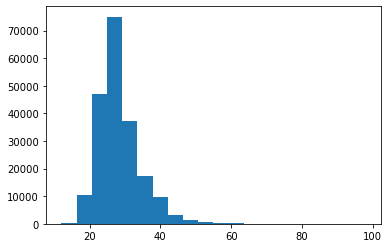

In [3]:
plt.hist(train['BMI'], bins = 20)

(array([36163., 71428., 60421., 25341.,  9591.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <a list of 5 Patch objects>)

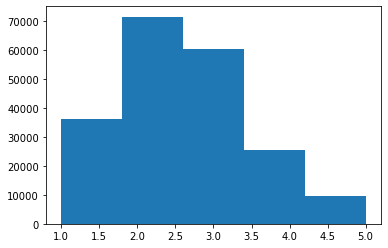

In [4]:
plt.hist(train['GenHlth'], bins = 5)

(array([1.40549e+05, 6.78300e+03, 1.03740e+04, 5.91900e+03, 3.03900e+03,
        7.28200e+03, 7.82000e+02, 2.46100e+03, 5.28000e+02, 6.80000e+01,
        5.06600e+03, 3.20000e+01, 3.10000e+02, 3.30000e+01, 9.38000e+02,
        4.39600e+03, 7.20000e+01, 4.70000e+01, 8.00000e+01, 1.40000e+01,
        2.72600e+03, 1.79000e+02, 5.00000e+01, 3.00000e+01, 2.30000e+01,
        9.72000e+02, 3.30000e+01, 6.60000e+01, 2.67000e+02, 9.82500e+03]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 <a list of 30 Patch objects>)

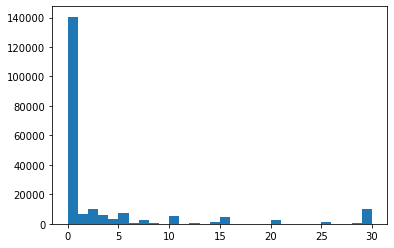

In [5]:
plt.hist(train['MentHlth'], bins = 30)

(array([1.28074e+05, 9.07900e+03, 1.18530e+04, 6.80800e+03, 3.64500e+03,
        6.08300e+03, 1.07100e+03, 3.61400e+03, 6.58000e+02, 1.38000e+02,
        4.50800e+03, 4.50000e+01, 4.70000e+02, 5.20000e+01, 2.05400e+03,
        3.92900e+03, 8.60000e+01, 7.90000e+01, 1.23000e+02, 1.70000e+01,
        2.61900e+03, 5.17000e+02, 5.70000e+01, 4.30000e+01, 5.50000e+01,
        1.05700e+03, 5.60000e+01, 8.80000e+01, 4.16000e+02, 1.56500e+04]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 <a list of 30 Patch objects>)

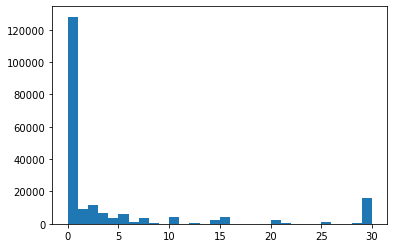

In [6]:
plt.hist(train['PhysHlth'], bins = 30)

(array([10583.,  8936., 24014., 15827., 45675., 26579., 44592., 26738.]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. ]),
 <a list of 8 Patch objects>)

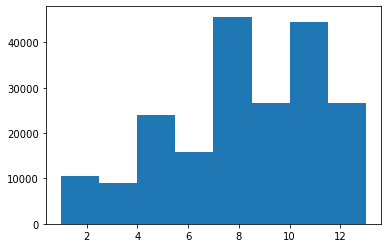

In [7]:
plt.hist(train['Age'], bins = 8)

(array([  133.,  3200.,  7627., 50248., 55870., 85866.]),
 array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
        5.16666667, 6.        ]),
 <a list of 6 Patch objects>)

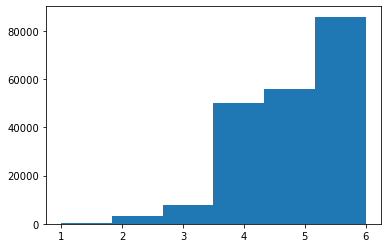

In [8]:
plt.hist(train['Education'], bins = 6)

(array([ 7821.,  9388., 12852., 16019., 20651., 29254., 34526., 72433.]),
 array([1.   , 1.875, 2.75 , 3.625, 4.5  , 5.375, 6.25 , 7.125, 8.   ]),
 <a list of 8 Patch objects>)

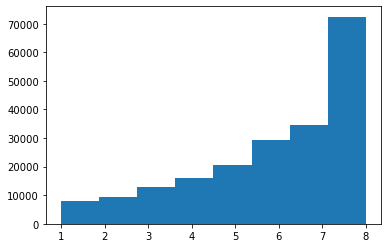

In [9]:
plt.hist(train['Income'], bins = 8)

### Feature Engineering

In [10]:
## BMI Categoricals

train['BMI_Underweight'] = np.where(train['BMI'] < 18.5, 1, 0)
train['BMI_Healthy'] = np.where((train['BMI'] >= 18.5) & (train['BMI'] < 25), 1, 0)
train['BMI_Overweight'] = np.where((train['BMI'] >= 25) & (train['BMI'] < 30), 1, 0)
train['BMI_Obese'] = np.where(train['BMI'] >= 30, 1, 0)

In [11]:
## Creating dummy variables for Sex, Education, and Income

train = pd.concat([train.drop(columns = ['Sex']), pd.get_dummies(train['Sex'])], axis = 1)
train = train.rename(columns = { 0: 'Female', 1: 'Male'})

train = pd.concat([train.drop(columns = ['Education']), pd.get_dummies(train['Education'])], axis = 1)
train = train.rename(columns = { 0: 'Never_Attended', 1: 'Grades_1_8', 3: 'Grades_9_11', 4: 'GED', 5: 'College_1_3', 
                              6: 'College_4+'})

train = pd.concat([train.drop(columns = ['Income']), pd.get_dummies(train['Income'])], axis = 1)
train = train.rename(columns = { 0: '<10,000', 1: '<15,000', 3: '<20,000', 4: '<25,000', 5: '<35,000', 
                                      6: '<50,000',  7: '<75,000',  6: '75,000+'})

In [12]:
## Fruits and Veggies
train['Fruits+Veggies'] = np.where((train['Fruits'] == 1) & (train['Veggies'] == 1), 1, 0)

## Health care issues
train['HealthCareIssues'] = np.where((train['AnyHealthcare'] == 0) & (train['NoDocbcCost'] == 0), 1, 0)

## Poor diet
train['PoorDiet'] = np.where((train['Fruits'] == 0) & (train['Veggies'] == 0) & 
                                (train['HvyAlcoholConsump'] == 1), 1, 0)

In [13]:
train.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Diabetes_012,BMI_Underweight,BMI_Healthy,BMI_Overweight,BMI_Obese,Female,Male,Grades_1_8,2.0,Grades_9_11,GED,College_1_3,College_4+,"<15,000",2.0,"<20,000","<25,000","<35,000","75,000+","<75,000",8.0,Fruits+Veggies,HealthCareIssues,PoorDiet
0,0.0,1.0,1.0,30.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,30.0,5.0,0.0,6.0,2.0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
1,1.0,1.0,1.0,30.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,11.0,0.0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,8.0,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
3,1.0,1.0,1.0,24.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,4.0,0.0,7.0,0.0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
4,0.0,0.0,1.0,35.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,7.0,0.0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0


In [14]:
train.shape

(202944, 42)